In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies = pd.read_csv('./tmdb_5000_movies.csv')
#movies['release_date']

In [3]:
#pd.to_datetime(movies['release_date']).apply(lambda x: x.date())
#movies['release_date']

In [4]:
#type(movies['genres'])

In [5]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date'])\
    .apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#join 将|加到中间
#‘-’.(a,b,c) = a - b- c
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

In [6]:
credits = load_tmdb_credits("./tmdb_5000_credits.csv")
movies = load_tmdb_movies("./tmdb_5000_movies.csv")

In [7]:
#type(movies['genres'])

In [8]:
del credits['title']
df = pd.concat([movies, credits], axis=1)

In [9]:
#df['genres']

In [10]:
df['genres'] = df['genres'].apply(pipe_flatten_names)

In [11]:
#df

In [12]:
#union取不相同且不带重复
#获得所有类型
liste_genres = set()
for s in df['genres'].str.split('|'):
    liste_genres = set().union(s, liste_genres)
liste_genres = list(liste_genres)
liste_genres.remove('')

In [13]:
#liste_genres

In [14]:
df_reduced = df[['title','vote_average','release_date',\
'runtime','budget','revenue']].reset_index(drop=True)
#df_reduced.head()

In [15]:
for genre in liste_genres:
    df_reduced[genre] = df['genres'].str.contains(genre)\
    .apply(lambda x:1 if x else 0)
#df_reduced[:5]

# 各个电影类型所占比例的图

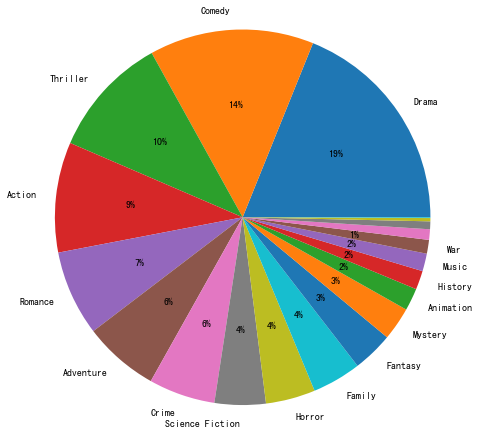

In [16]:
#rc = run configuration
plt.rc('font', weight='bold')
#创建画纸
f, ax = plt.subplots(figsize=(6,6))
genre_count = []
#获得一个类型，类型总数的列表
for genre in liste_genres:
    genre_count.append([genre, df_reduced[genre].values.sum()])

#sort默认从小到大
genre_count.sort(key = lambda x:x[1], reverse = True)
#zip 不仅可以聚合，也可以分开
labels, sizes = zip(*genre_count)

#选择大于百分之一的
labels_selected = [n if v > sum(sizes) * 0.01 else '' \
                   for n, v in genre_count]

#startangle x轴逆时针开始转动
ax.pie(sizes, labels=labels_selected,
      autopct = lambda x:'{:.0f}%'.format(x) if x>1 else '',
      shadow = False, startangle=0)
ax.axis('equal')
#暂时理解为使排榜清晰的一个函数
plt.tight_layout()

In [17]:
mean_per_genre = pd.DataFrame(liste_genres)

In [18]:
#df_reduced

In [19]:
#df_reduced.groupby('History', as_index=True).sum()

In [20]:

#df_reduced.groupby('Mystery', as_index=True).sum()

In [21]:
#为什么newArray有两个行向量，因为有0 ， 1两种可能，而我们要取的是1，so
newArray = []*len(liste_genres)
#groupby 按某个变量分类
for genre in liste_genres:
    newArray.append(df_reduced.groupby(genre, as_index=True)\
                    ['vote_average'].mean())
#print(newArray)
newArray2 = []*len(liste_genres)
for i in range(len(liste_genres)):
    newArray2.append(newArray[i][1])
#print(newArray2)
mean_per_genre['mean_votes_average']=newArray2

In [22]:
newArray = []*len(liste_genres)
for genre in liste_genres:
    newArray.append(df_reduced.groupby(genre, as_index=True)['budget'].mean())
newArray2 = []*len(liste_genres)
for i in range(len(liste_genres)):
    newArray2.append(newArray[i][1])

mean_per_genre['mean_budget']=newArray2

In [23]:
newArray = []*len(liste_genres)
for genre in liste_genres:
    newArray.append(df_reduced.groupby(genre, as_index=True)['revenue'].mean())
newArray2 = []*len(liste_genres)
for i in range(len(liste_genres)):
    newArray2.append(newArray[i][1])

mean_per_genre['mean_revenue']=newArray2

In [24]:
mean_per_genre['profit'] = mean_per_genre['mean_revenue']\
                            -mean_per_genre['mean_budget']

In [25]:
#mean_per_genre

# 每个电影类型的平均投票数

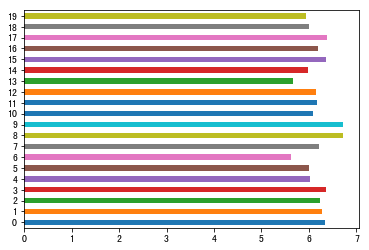

In [26]:
mean_per_genre['mean_votes_average'].plot.barh()

# 每年每一种类型的平均值

In [27]:
from datetime import datetime

t = df_reduced['release_date']
t = pd.to_datetime(t)
t = t.dt.year
df_reduced['release_year'] = t

In [28]:
df_list = []*len(liste_genres)
for genre in liste_genres:
    df_list.append(df_reduced.groupby([genre,'release_year'])\
                   .mean().reset_index())

In [29]:
#df_list

In [30]:
#去0得1
df_per_genre = []*len(liste_genres)
for i in range(len(df_list)):
    df_per_genre.append(df_list[i][df_list[i].iloc[:,0] == 1])

In [31]:
columns = range(1988,2018)
budget_genre = pd.DataFrame( columns = columns)
budget_genre

,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017


In [32]:
for genre in liste_genres:
    temp=(df_per_genre[liste_genres.index(genre)].pivot_table\
          (index = genre, columns = 'release_year', \
           values = 'budget', aggfunc = np.mean))
    #print(temp)
    temp = temp[temp.columns[-30:]].loc[1]
    #print(temp)
    budget_genre.loc[liste_genres.index(genre)] = temp
budget_genre['genre']=liste_genres

In [33]:
budget_genre.index = budget_genre['genre']
budget_genre

,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,genre
genre,,,,,,,,,,,,,,,,,,,,,
Animation,1.015000e+07,NaN,NaN,NaN,2.800000e+07,2.800000e+07,4.500000e+07,4.250000e+07,4.800000e+07,3.716667e+07,...,7.900000e+07,9.184615e+07,8.717647e+07,8.334743e+07,7.844118e+07,6.464286e+07,7.092308e+07,7.800000e+07,NaN,Animation
Crime,1.282500e+07,2.300000e+07,4.375000e+07,1.641667e+07,1.523869e+07,2.187500e+07,2.776923e+07,2.631250e+07,2.217647e+07,3.463487e+07,...,2.304330e+07,2.426559e+07,3.657083e+07,3.061967e+07,3.291946e+07,2.157185e+07,3.630000e+07,4.017500e+07,NaN,Crime
Documentary,NaN,1.600000e+05,NaN,NaN,NaN,NaN,7.000000e+05,NaN,NaN,0.000000e+00,...,1.600000e+07,4.285714e+06,3.850857e+06,1.858333e+06,1.260000e+06,1.304429e+05,6.746231e+05,NaN,NaN,Documentary
Foreign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.250000e+06,...,8.125018e+05,0.000000e+00,0.000000e+00,2.250000e+05,NaN,NaN,NaN,NaN,NaN,Foreign
Family,1.515000e+07,2.000000e+07,1.525000e+07,2.510000e+07,1.400000e+07,3.256250e+07,3.383333e+07,3.500000e+07,3.869125e+07,3.113111e+07,...,6.843750e+07,7.154310e+07,6.648036e+07,6.961863e+07,8.284062e+07,6.386957e+07,7.196176e+07,7.677778e+07,0.0,Family
Science Fiction,8.750000e+06,3.000000e+07,3.380000e+07,3.160000e+07,2.160000e+07,1.942857e+07,2.900000e+07,3.800000e+07,5.133333e+07,5.447368e+07,...,7.679688e+07,5.022895e+07,5.538656e+07,7.196136e+07,8.151852e+07,7.793462e+07,7.628304e+07,1.045455e+08,NaN,Science Fiction
Horror,4.733333e+06,6.083333e+06,2.000000e+07,2.050000e+07,2.050000e+07,1.666667e+06,2.900000e+07,1.000000e+07,2.250000e+07,3.990200e+07,...,1.178334e+07,1.639074e+07,1.572576e+07,1.151394e+07,1.675803e+07,1.102143e+07,4.919697e+06,9.720000e+06,NaN,Horror
Romance,1.066667e+07,1.333333e+07,1.320000e+07,1.100000e+07,2.524365e+07,1.249091e+07,3.022222e+07,2.091765e+07,2.131905e+07,2.458333e+07,...,1.874380e+07,2.892811e+07,2.374046e+07,1.844744e+07,1.796889e+07,2.831250e+07,1.733043e+07,1.377778e+07,NaN,Romance
History,NaN,4.580000e+06,NaN,4.000000e+07,3.633333e+07,1.566667e+07,1.800000e+07,5.533333e+07,1.524051e+07,3.683333e+07,...,3.581250e+07,1.121839e+07,2.839175e+07,4.375000e+07,1.585750e+07,3.342857e+07,2.955556e+07,3.458333e+07,NaN,History


## 收入

In [34]:
columns = range(1988,2018)
revenue_genre = pd.DataFrame( columns = columns)
revenue_genre

,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017


In [35]:
for genre in liste_genres:
    temp=(df_per_genre[liste_genres.index(genre)].pivot_table(index = genre, columns = 'release_year', values = 'revenue', aggfunc = np.mean))
    temp = temp[temp.columns[-30:]].loc[1]
    revenue_genre.loc[liste_genres.index(genre)]=temp
revenue_genre['genre']=liste_genres

In [36]:
revenue_genre.index = revenue_genre['genre']
revenue_genre

,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,genre
genre,,,,,,,,,,,,,,,,,,,,,
Animation,4.250701e+07,NaN,NaN,NaN,5.040502e+08,6.692760e+05,7.882418e+08,3.598169e+08,8.758471e+07,1.009154e+08,...,2.433655e+08,3.199310e+08,2.466578e+08,2.754644e+08,3.010980e+08,2.201954e+08,3.140907e+08,4.719153e+08,NaN,Animation
Crime,2.593798e+07,5.225724e+07,7.694114e+07,1.049300e+08,8.962918e+07,7.733952e+07,1.219430e+08,7.811012e+07,4.683539e+07,6.534840e+07,...,4.865874e+07,4.074380e+07,9.365526e+07,9.149609e+07,6.650704e+07,4.022622e+07,7.479586e+07,1.388020e+08,NaN,Crime
Documentary,NaN,6.706368e+06,NaN,NaN,NaN,NaN,7.830611e+06,NaN,NaN,0.000000e+00,...,7.368583e+06,1.846765e+07,1.682173e+07,7.503113e+06,3.223091e+06,0.000000e+00,0.000000e+00,NaN,NaN,Documentary
Foreign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,...,1.750000e+00,0.000000e+00,0.000000e+00,1.113000e+05,NaN,NaN,NaN,NaN,NaN,Foreign
Family,1.180648e+08,1.660000e+08,1.841455e+08,8.272960e+07,2.352689e+08,8.547552e+07,2.227296e+08,2.279945e+08,6.253141e+07,3.930420e+07,...,2.066505e+08,2.235535e+08,1.792851e+08,2.302810e+08,2.705075e+08,2.114126e+08,2.817845e+08,3.477137e+08,0.0,Family
Science Fiction,8.674738e+06,1.067135e+08,1.279649e+08,1.391539e+08,4.259434e+07,1.390742e+08,7.662750e+07,9.667365e+07,1.668067e+08,1.224596e+08,...,2.381428e+08,1.541972e+08,1.669972e+08,2.280335e+08,2.662696e+08,2.908823e+08,2.588725e+08,3.323677e+08,NaN,Science Fiction
Horror,2.093621e+07,1.754668e+07,3.435932e+07,1.131872e+08,7.415122e+07,5.330757e+06,8.319183e+07,2.671513e+07,4.760999e+07,8.983488e+07,...,3.082346e+07,4.421287e+07,3.788669e+07,3.778651e+07,7.184334e+07,4.408987e+07,2.068814e+07,4.222806e+07,NaN,Horror
Romance,6.211316e+07,3.094118e+07,2.074307e+08,1.939886e+07,1.950059e+08,2.854121e+07,2.126254e+08,4.045968e+07,5.061994e+07,1.278945e+08,...,5.463998e+07,7.386076e+07,6.911425e+07,7.524173e+07,4.219857e+07,7.939355e+07,7.118764e+07,4.963900e+07,NaN,Romance
History,NaN,3.353184e+06,NaN,2.054055e+08,4.122525e+07,1.342902e+08,5.887457e+06,7.802139e+07,3.704187e+07,6.848589e+07,...,5.260018e+07,5.899821e+07,3.896373e+07,1.170256e+08,5.855735e+07,8.265211e+07,5.544324e+07,3.744987e+07,NaN,History


## 投票

In [37]:
columns = range(1988,2018)
vote_avg_genre = pd.DataFrame( columns = columns)
vote_avg_genre

,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017


In [38]:
for genre in liste_genres:
    temp=(df_per_genre[liste_genres.index(genre)].pivot_table(index = genre, columns = 'release_year', values = 'vote_average', aggfunc = np.mean))
    temp = temp[temp.columns[-30:]].loc[1]
    vote_avg_genre.loc[liste_genres.index(genre)]=temp
vote_avg_genre['genre']=liste_genres

In [39]:
vote_avg_genre.index = vote_avg_genre['genre']
vote_avg_genre

,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,genre
genre,,,,,,,,,,,,,,,,,,,,,
Animation,7.400000,NaN,NaN,NaN,7.400000,6.800000,8.000000,7.200000,6.200000,7.566667,...,6.480000,6.300000,5.882353,6.176923,6.323529,6.078571,6.476923,6.025000,NaN,Animation
Crime,6.350000,6.166667,6.850000,6.683333,6.490909,6.487500,6.338462,6.300000,6.305882,6.387500,...,6.021875,6.123333,6.295833,5.955556,6.183784,5.762963,5.419231,5.550000,NaN,Crime
Documentary,NaN,7.400000,NaN,NaN,NaN,NaN,7.700000,NaN,NaN,6.300000,...,6.540000,6.142857,5.785714,6.711111,6.400000,3.528571,3.542857,NaN,NaN,Documentary
Foreign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.300000,...,6.350000,5.200000,5.750000,6.900000,NaN,NaN,NaN,NaN,NaN,Foreign
Family,6.950000,6.500000,6.250000,6.360000,6.825000,5.900000,5.833333,6.533333,5.712500,6.033333,...,6.160714,5.762069,5.892857,5.970588,6.013636,6.156522,5.900000,6.211111,7.4,Family
Science Fiction,6.625000,6.540000,6.220000,6.140000,5.740000,5.985714,5.450000,5.540000,5.822222,5.721053,...,5.878125,5.947368,6.065385,6.068182,6.259259,6.088462,5.807143,6.118182,NaN,Science Fiction
Horror,6.022222,5.500000,5.300000,5.900000,6.266667,5.100000,6.666667,5.583333,6.000000,6.020000,...,5.706667,5.529630,5.412500,5.181818,5.208000,4.914286,4.984848,5.600000,NaN,Horror
Romance,6.600000,6.966667,6.840000,5.700000,6.700000,6.945455,6.533333,6.317647,6.133333,6.176190,...,6.129825,6.055556,6.180000,6.238462,6.540000,6.270833,6.352174,5.944444,NaN,Romance
History,NaN,7.400000,NaN,7.500000,6.800000,7.433333,7.300000,6.766667,6.100000,7.166667,...,6.900000,6.700000,5.750000,6.425000,7.025000,6.285714,6.566667,6.700000,NaN,History


In [40]:
len(budget_genre)

20

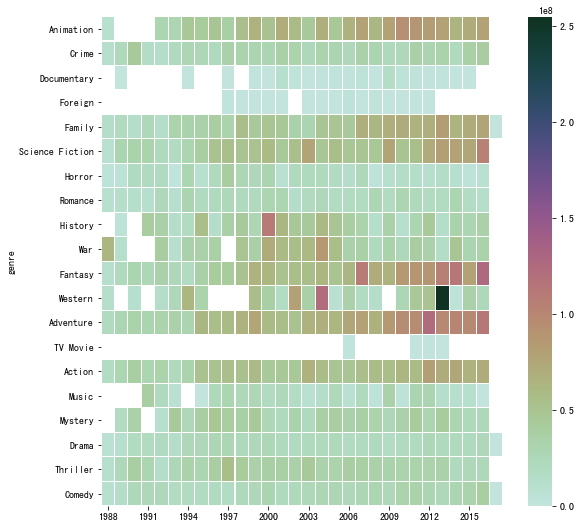

In [42]:
fig, ax = plt.subplots(figsize=(9,9))
cmap = sns.cubehelix_palette(start = 1.5, rot = 1.5, as_cmap = True)
sns.heatmap(budget_genre.iloc[:,0:30], xticklabels=3, cmap=cmap, linewidths=0.05)